In [1]:
import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting QQQ quotes
stockname = 'QQQ'
symbol = 'QQQ'

# Use yfinance to load the data from yahoo finance
import yfinance as yf
df = yf.download(symbol, start=start_date, end=end_date)

# Create a quick overview of the dataset
df.head()


Tensorflow Version: 2.12.0
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,46.330002,46.490002,46.270000,46.419998,40.949310,62822800
2010-01-05,46.389999,46.500000,46.160000,46.419998,40.949310,62935600
2010-01-06,46.400002,46.549999,46.070000,46.139999,40.702286,96033000
2010-01-07,46.209999,46.270000,45.919998,46.169998,40.728752,77094100
2010-01-08,46.070000,46.549999,45.930000,46.549999,41.063976,88886600


In [2]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-07-24,377.579987,374.339996,376.619995,376.230011,40380100,376.230011
2023-07-25,380.470001,376.929993,376.950012,378.779999,38894400,378.779999
2023-07-26,379.239990,375.179993,377.720001,377.519989,47075700,377.519989
2023-07-27,384.709991,375.309998,383.070007,376.619995,63940200,376.619995
2023-07-28,384.519989,380.220001,380.739990,383.480011,56853400,383.480011


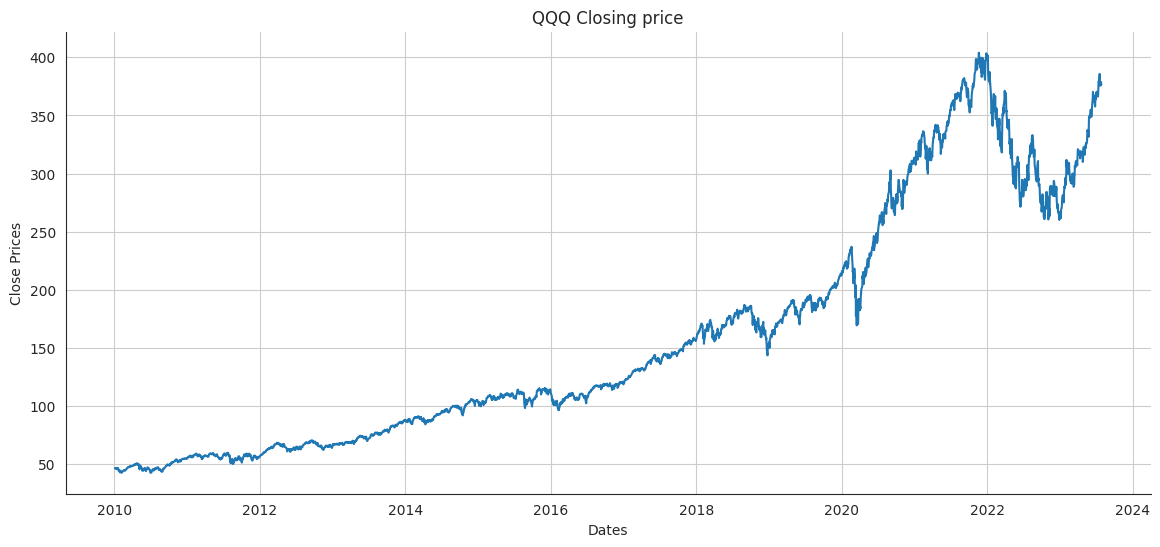

In [ ]:
# Plotting the closing prices
plt.figure(figsize=(14,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title(f'{stockname} Closing price')
plt.show()


In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3414, 5)


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2682, 50, 5) (2682,)
(682, 50, 5) (682,)
0.014383705206534342
0.014383705206534342


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [ ]:
# Training the model
epochs = 100
batch_size = 32
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

                    #callbacks=[early_stop])

Epoch 1/100
84/84 [==============================] - 41s 430ms/step - loss: 0.0027 - val_loss: 7.4058e-04
Epoch 2/100
84/84 [==============================] - 40s 473ms/step - loss: 9.1862e-05 - val_loss: 6.2720e-04
Epoch 3/100
84/84 [==============================] - 37s 436ms/step - loss: 8.0224e-05 - val_loss: 5.8028e-04
Epoch 4/100
84/84 [==============================] - 34s 409ms/step - loss: 7.9101e-05 - val_loss: 6.6625e-04
Epoch 5/100
84/84 [==============================] - 35s 410ms/step - loss: 8.3898e-05 - val_loss: 5.3429e-04
Epoch 6/100
84/84 [==============================] - 35s 421ms/step - loss: 8.6779e-05 - val_loss: 8.2986e-04
Epoch 7/100
84/84 [==============================] - 35s 415ms/step - loss: 7.6068e-05 - val_loss: 5.1421e-04
Epoch 8/100
84/84 [==============================] - 35s 409ms/step - loss: 1.0338e-04 - val_loss: 5.1678e-04
Epoch 9/100
84/84 [==============================] - 36s 426ms/step - loss: 6.7740e-05 - val_loss: 5.7767e-04
Epoch 10/100
8

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 6s 124ms/step
Median Absolute Error (MAE): 4.74
Mean Absolute Percentage Error (MAPE): 1.48 %
Median Absolute Percentage Error (MDAPE): 1.28 %


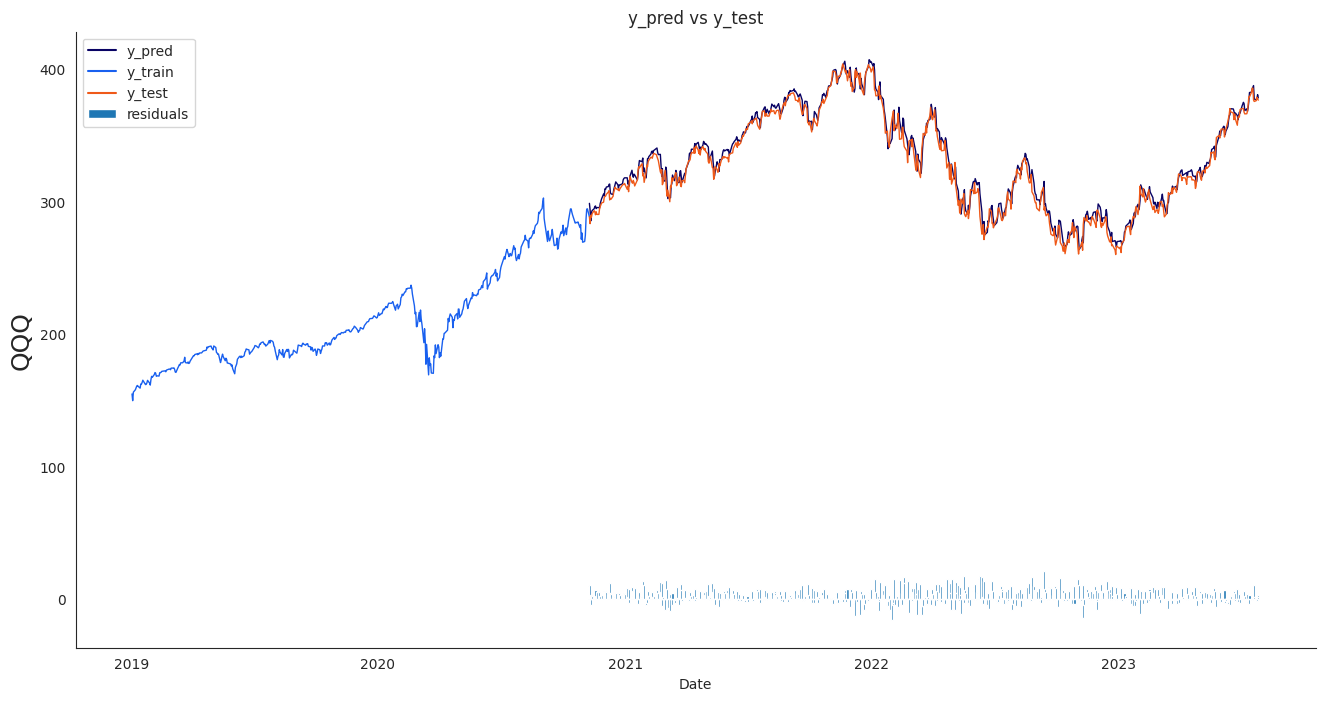

In [ ]:
# The date from which on the date is displayed
display_start_date = "2019-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals')
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} is {price_today}')
print(f'The predicted close price for next day is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 48ms/step
The close price for QQQ at 2023-07-28 is 376.62
The predicted close price for next day is 378.94000244140625 (+0.61%)
